In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import os
import missingno as msno

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

from src.utils import show_feature_importances

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

### Загрузка датасета

In [3]:
data_path='./data/'

train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
client_profile_data = pd.read_csv(os.path.join(data_path, "client_profile.csv"))

print("payments_data.shape = {} rows, {} cols".format(*client_profile_data.shape))

payments_data.shape = 250000 rows, 24 cols


# Results

In [4]:
client_profile_data['DAYS_ON_LAST_JOB'][client_profile_data['DAYS_ON_LAST_JOB']==365243] = np.nan

In [5]:
client_profile_data.head(3)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326.0,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
client_profile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            205133 non-null  float64
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [7]:
client_profile_data.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,205133.000000,85041.000000,250000.000000,250000.000000,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,2384.370837,12.030221,0.280244,0.057072,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,2337.929285,11.899404,0.449119,0.231981,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,767.000000,5.000000,0.000000,0.000000,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,1650.000000,9.000000,0.000000,0.000000,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,3176.000000,15.000000,1.000000,0.000000,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,17912.000000,69.000000,1.000000,1.000000,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [8]:
for col in client_profile_data.columns[2:]:
    print(f'{col}: n_uniques:{client_profile_data[col].nunique()} list:{client_profile_data[col].unique()}')

CHILDRENS: n_uniques:15 list:[ 0  1  2  4  3  6  5 12 14  8  7 19  9 10 11]
TOTAL_SALARY: n_uniques:2198 list:[157500.  270000.  427500.  ... 209587.5 197433.   65997. ]
AMOUNT_CREDIT: n_uniques:5295 list:[ 270000.   536917.5  239850.  ... 1167781.5  766552.5  388746. ]
AMOUNT_ANNUITY: n_uniques:13151 list:[13500.  28467.  23850.  ... 65227.5  8014.5  2425.5]
EDUCATION_LEVEL: n_uniques:5 list:['Incomplete higher' 'Secondary / secondary special' 'Lower secondary'
 'Higher education' 'Academic degree']
FAMILY_STATUS: n_uniques:6 list:['Civil marriage' 'Married' 'Widow' 'Single / not married' 'Separated'
 'Unknown']
REGION_POPULATION: n_uniques:81 list:[0.008068 0.020246 0.072508 0.019101 0.022625 0.018029 0.04622  0.025164
 0.0105   0.004849 0.01452  0.008019 0.011703 0.026392 0.011657 0.005313
 0.019689 0.020713 0.009549 0.031329 0.015221 0.01885  0.0228   0.035792
 0.010643 0.028663 0.030755 0.00963  0.02461  0.010276 0.010032 0.009175
 0.018634 0.001276 0.005084 0.010147 0.018801 0.00

In [9]:
data = client_profile_data.merge(train_data[['APPLICATION_NUMBER', 'TARGET']], how='left', on='APPLICATION_NUMBER')
data = data.dropna(subset=['TARGET'])
data = data.reset_index(drop=True)

In [10]:
numerical_features = data.drop(['APPLICATION_NUMBER', 'TARGET'], axis=1).select_dtypes(include=[np.number]).columns
categorical_features = data.select_dtypes(include=[np.object]).columns

In [11]:
data[numerical_features].head(5)

,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,427500.0,239850.0,23850.0,0.072508,14387,326.0,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,108000.0,835380.0,35523.0,0.019101,16213,2618.0,NaN,0,0,2.0,NaN,0.434042,0.646330,0.0,0.0,0.0,0.0,1.0,2.0
2,0,135000.0,592560.0,31023.0,0.018029,9219,2412.0,NaN,0,0,2.0,NaN,0.366381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,220500.0,1113840.0,47322.0,0.046220,14010,3489.0,NaN,0,0,3.0,0.418500,0.559779,NaN,0.0,0.0,0.0,0.0,0.0,3.0
4,1,76500.0,177768.0,8550.0,0.010500,17203,8280.0,NaN,1,0,3.0,0.434592,0.541889,0.517297,0.0,0.0,0.0,2.0,0.0,0.0


In [12]:
data[categorical_features].head(5)

,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
0,M,Incomplete higher,Married
1,F,Secondary / secondary special,Married
2,M,Secondary / secondary special,Married
3,F,Secondary / secondary special,Civil marriage
4,F,Secondary / secondary special,Married


In [13]:
for col in categorical_features:
    print(f'{col}: n_uniques:{data[col].nunique()} list:{data[col].unique()}')

GENDER: n_uniques:3 list:['M' 'F' 'XNA']
EDUCATION_LEVEL: n_uniques:5 list:['Incomplete higher' 'Secondary / secondary special' 'Higher education'
 'Lower secondary' 'Academic degree']
FAMILY_STATUS: n_uniques:6 list:['Married' 'Civil marriage' 'Single / not married' 'Widow' 'Separated'
 'Unknown']


In [14]:
categorical_features

Index(['GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], dtype='object')

<AxesSubplot:>

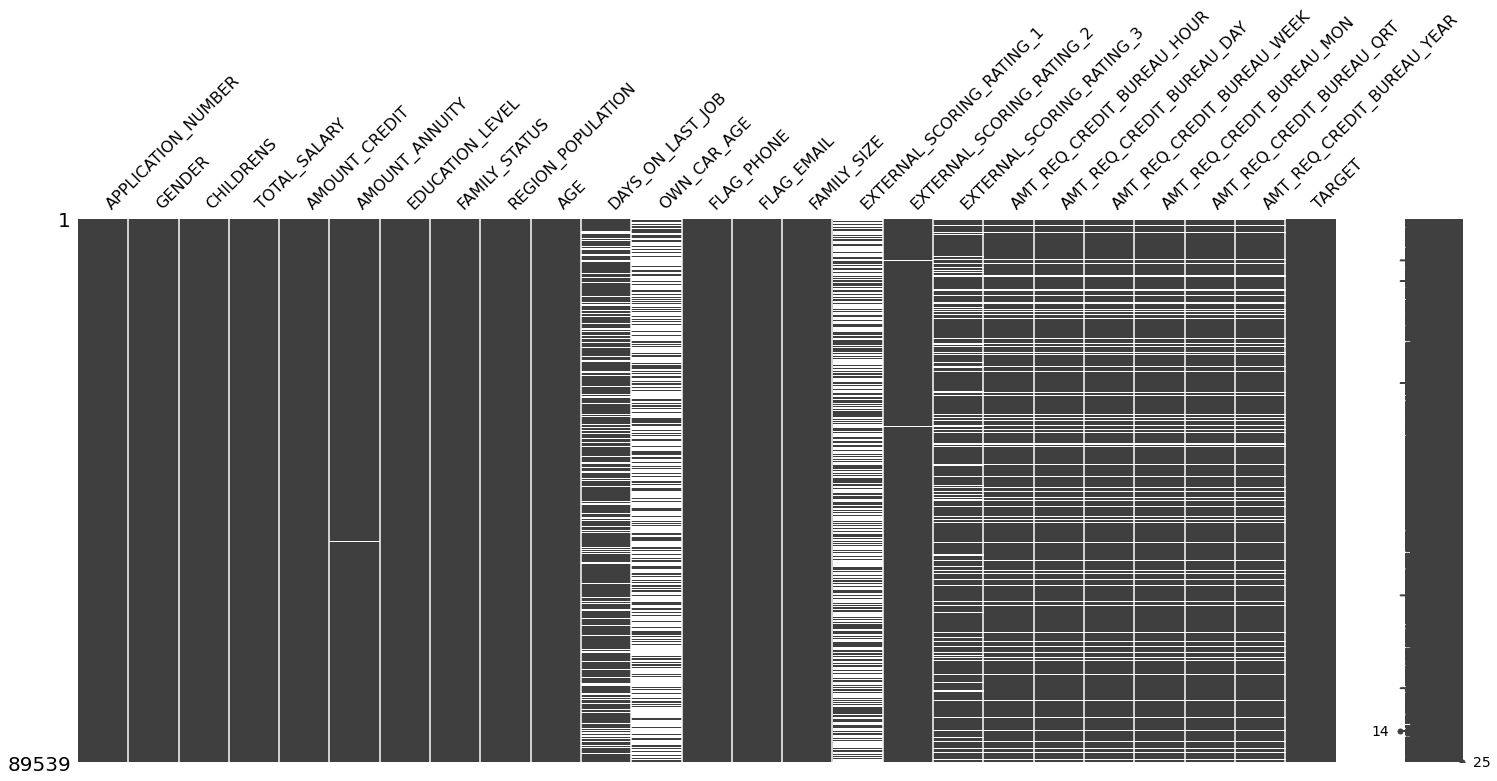

In [15]:
msno.matrix(data)

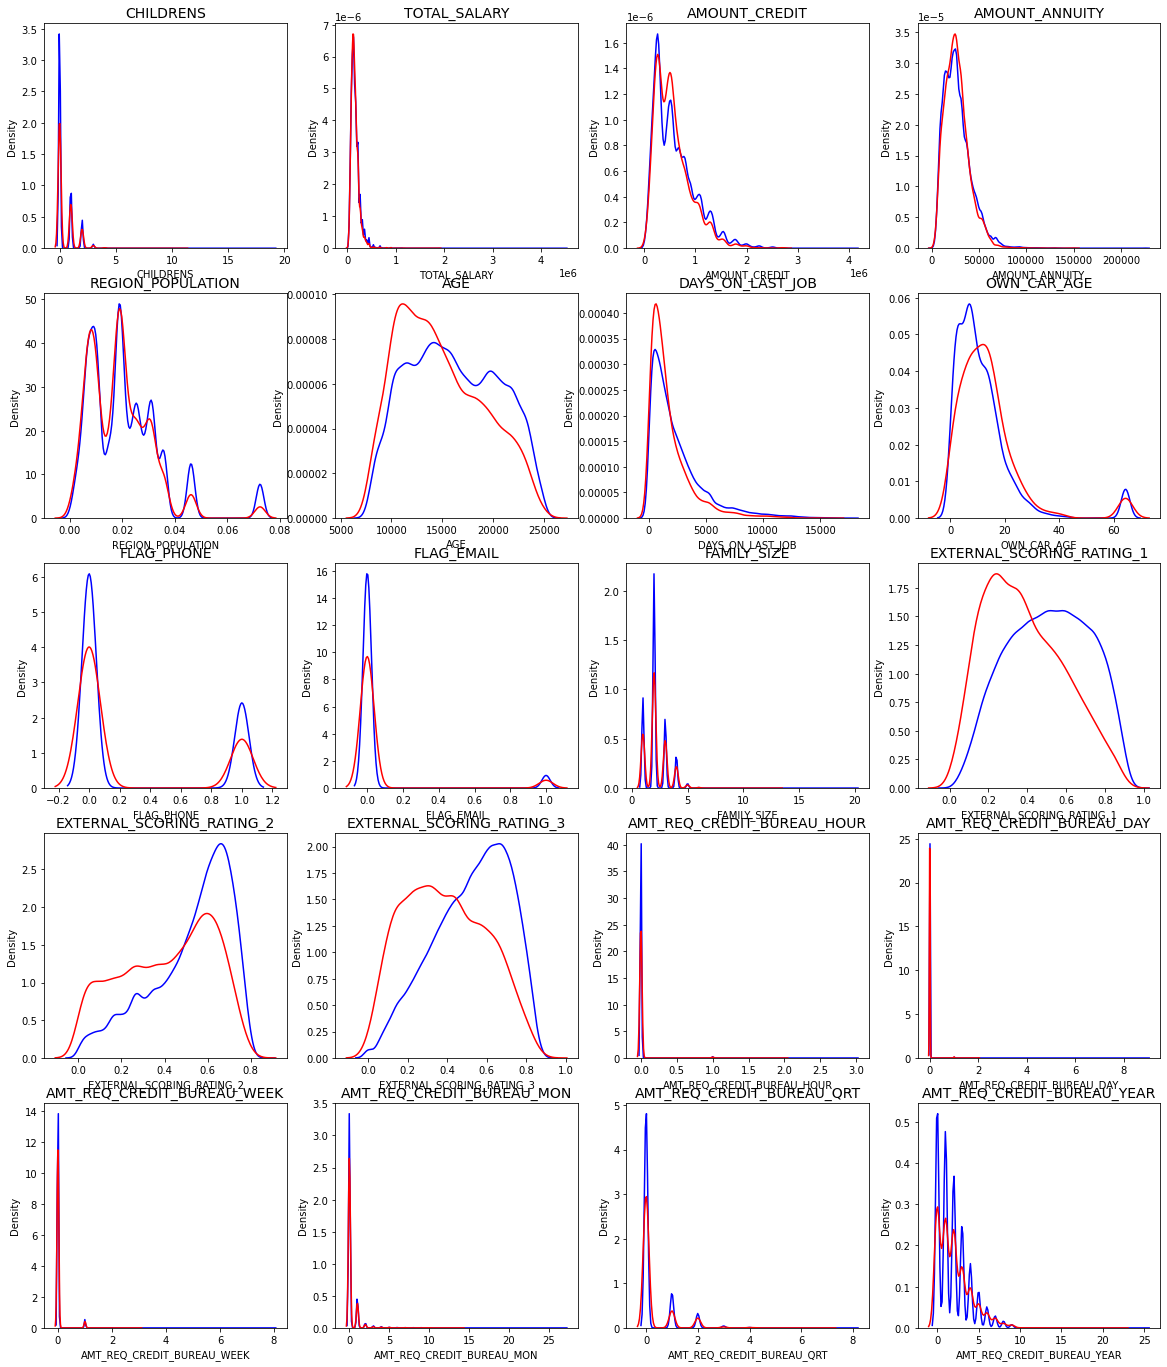

In [16]:
fig, axes = plt.subplots(5, 4, figsize=(20, 24))

for num, feature in enumerate(numerical_features):
    try:
        train_target_0, test_target_1 = data[data['TARGET']==0][feature].copy(), data[data['TARGET']==1][feature].copy()
        sns.kdeplot(train_target_0, ax=axes[num//4, num%4], color="blue", label="target=0")
        sns.kdeplot(test_target_1, ax=axes[num//4, num%4], color="red", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)

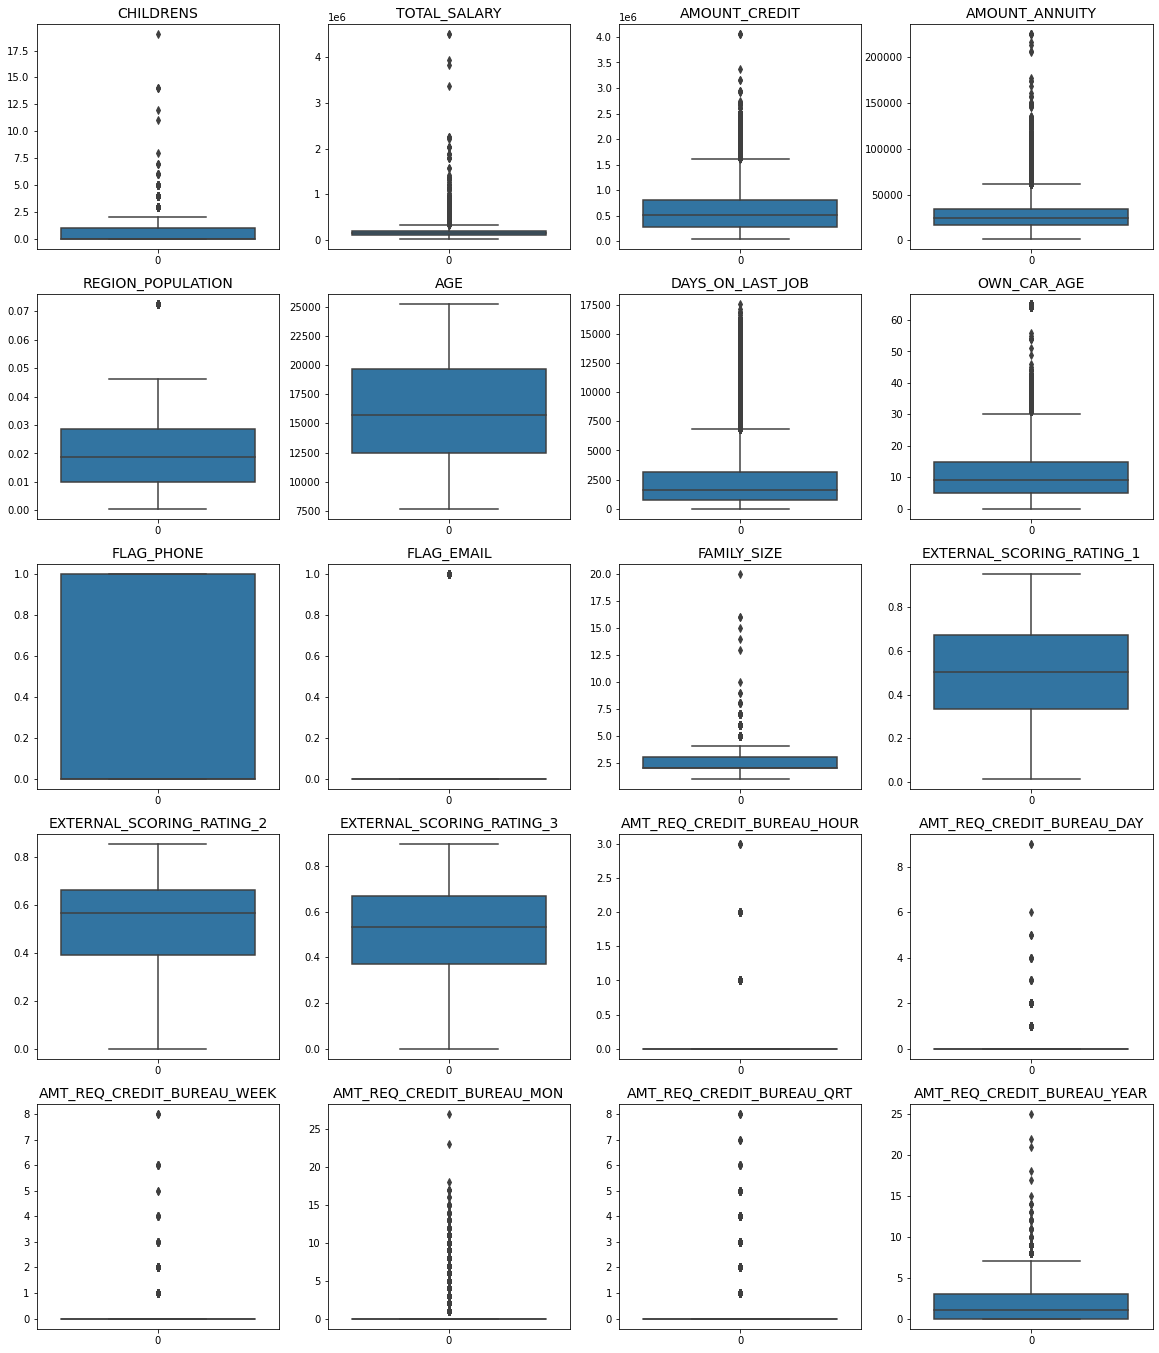

In [17]:
fig, axes = plt.subplots(5, 4, figsize=(20, 24))

for num, feature in enumerate(numerical_features):
    try:
        sns.boxplot(data=data[feature], ax=axes[num//4, num%4])
    except RuntimeError:
        pass
    except KeyError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)

In [18]:
correlation = data.corr()

<AxesSubplot:>

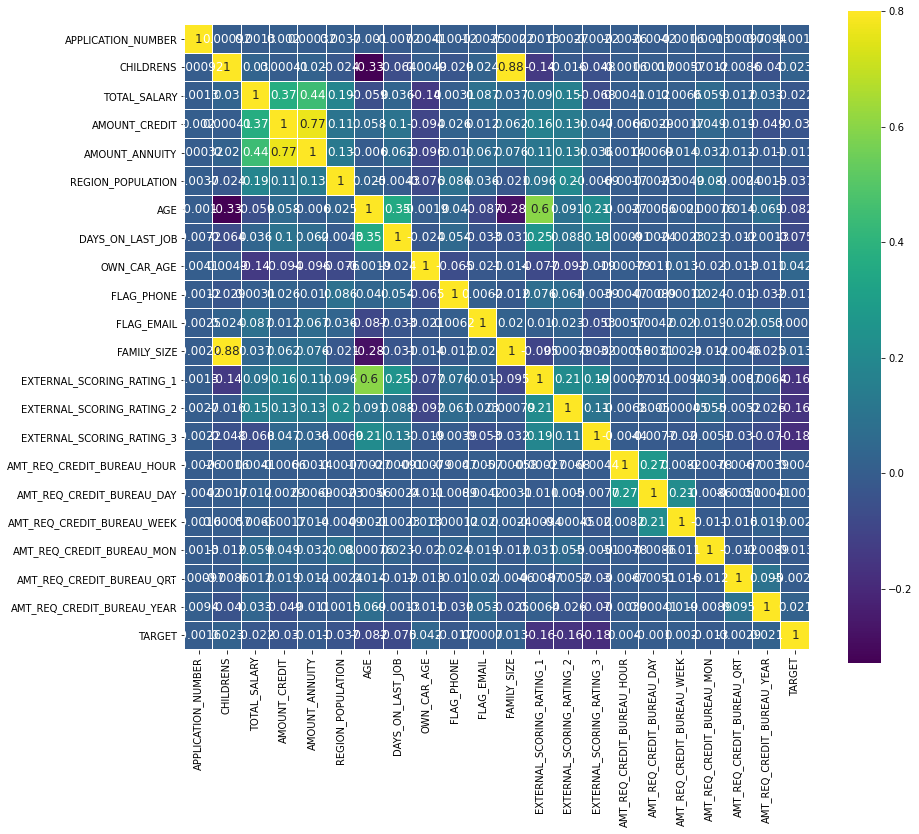

In [19]:
fig, axes = plt.subplots(figsize = (14, 12))
sns.heatmap(
    correlation,
    vmax=0.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=correlation.columns,
    annot_kws = {"size": 12},
    yticklabels=correlation.columns
)